In [10]:
import json
import numpy as np
import pandas as pd
import matplotlib
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm


selfrag-7b arc_c selfrag policy


100%|███████████████████████████████████████████████████████████████████████| 1172/1172 [00:00<00:00, 2779.86it/s]


selfrag-7b arc_c random policy


100%|███████████████████████████████████████████████████████████████████████| 1173/1173 [00:00<00:00, 1729.60it/s]


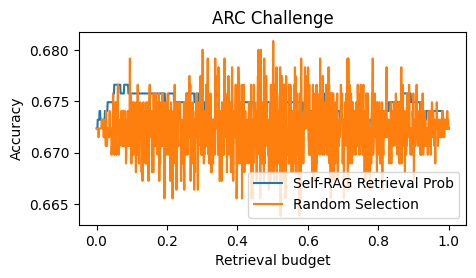

In [18]:
task = 'arc_c'
task_plotname = 'ARC Challenge' # 'PopQA' 'PubHealth'

for model in ['selfrag-7b']:
    infile_always_rag = f'/home/diwu/ralm/self-rag/results/{task}/adaptive-rag/{model}.json'
    infile_no_rag = f'/home/diwu/ralm/self-rag/results/{task}/adaptive-rag/{model}-t0.9.json'
    infile_probs = f'/home/diwu/ralm/self-rag/results/{task}/adaptive-rag/selfrag-7b-t0.2.json.retrievalprobs.json'
    
    scores_no_rag = json.load(open(infile_no_rag))['metric_results']
    scores_always_rag = json.load(open(infile_always_rag))['metric_results']
    probs = json.load(open(infile_probs))

    assert len(scores_no_rag) == len(scores_always_rag) == len(probs)
    
    trace = []
    for score_baseline, score_rag, prob in zip(scores_no_rag, scores_always_rag, probs):
        trace.append({
            'score_baseline': score_baseline,
            'score_rag': score_rag,
            'retrieval_prob': prob
        })

    plt.figure(figsize=(5, 2.5))   

    # policy 1 - selfrag
    print(model, task, 'selfrag policy')
    x, y = [], []
    thresholds = sorted(list(set(probs)), reverse=True)
    for t in tqdm(thresholds):
        all_scores = [x['score_baseline'] for x in trace if x['retrieval_prob'] < t] + [x['score_rag'] for x in trace if x['retrieval_prob'] >= t]
        budget = len([x['score_rag'] for x in trace if x['retrieval_prob'] >= t]) / len(trace)
        x.append(budget)
        y.append(np.mean(all_scores))
    sns.lineplot(x=x, y=y, label='Self-RAG Retrieval Prob')

    # policy 2 - random
    print(model, task, 'random policy')
    x, y = [], []
    thresholds = random.shuffle(thresholds)
    budgets = list(range(len(trace)+1))
    for b in tqdm(budgets):
        random.shuffle(trace)
        x.append(b / len(trace))
        all_scores = [x['score_rag'] for x in trace[:b]] + [x['score_baseline'] for x in trace[b:]]
        y.append(np.mean(all_scores))
    sns.lineplot(x=x, y=y, label='Random Selection')
    
    plt.xlabel('Retrieval budget')
    plt.ylabel('Accuracy')
    plt.title(task_plotname)
    plt.legend()
    plt.show()
